<a href="https://colab.research.google.com/github/c-gohlke/Explainable-Recommendations-through-Deep-Reinforcement-Learning/blob/master/Explainable_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable Knowledge Graph-based Recommendation via Deep Reinforcement Learning**

A recommender system is a system that aims to make meaningful recommendations for a user. In the context of this semester project, the goal was to recommend movies for different users. The state-of-the-art recommendation systems of today generally don’t have the ability to provide meaningful reasons why a recommendation was made, which is the challenge that will be tackled here. One of the goals is to be able to explain why the recommendation was made. Recent studies show that explainable recommendation helps to improve the transparency, persuasiveness, effectiveness, trustworthiness, and satisfaction of recommendation. [1]

In this notebook, I have applied three algorithm techniques to provide recommendations: ItemKNN [2], Bayesian Personalized Ranking Matrix Factorization [3], and EKAR (Explainable Knowledge Graph-based Recommendation via Deep Reinforcement Learning) [4]. I will ﬁrst provide an analysis of the dataset used, then show a brief overview of the mode of operation of each algorithm, as well as the results obtained.

## **I) Dataset Analysis**

### Step1: Loading and preprocessing the data


In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from matplotlib import pyplot as plt 
from operator import itemgetter
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle

drive.mount('/content/drive')
!unzip '/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ml-1m.zip'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


There are some missing movieIds in the used dataset: there are 3706 movies and their ids range from 1 to 3952.

Because we will use many matrix operations, we replace the ids such that the ids of the users range from 0 to len(users) and the ids of the movies go from 0 to len(movies).

This will allow easier manipulation of the matrices, as matrix[0] can be used to represent the information related to movie with id 0.

In [3]:
def load_data():
    print("loading/preprocessing data")
    df = pd.read_csv(os.path.join('ml-1m', 'ratings.dat'), 
            sep=r':{2,}', 
            usecols=[0,1,2,3],
            names=['userId', 'movieId', 'rating', 'timestamp'],
            engine='python')

    movies = sorted(set(df['movieId']))
    movies = {c: i for (i, c) in enumerate(movies)}

    users = sorted(set(df["userId"]))
    users = {c: i for (i, c) in enumerate(users)}

    #replace the ids
    df['userId'] = df['userId'].replace(users)
    df['movieId'] = df['movieId'].replace(movies)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/df.pickle', 'wb') as handle:
          pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/users.pickle', 'wb') as handle:
          pickle.dump(users, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/movies.pickle', 'wb') as handle:
          pickle.dump(movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return df, users, movies

Because the preprocessing step is slow, we store the information as a loadable array, such that we can simply load the precomputed arrays in the future.

In [2]:
# df, users, movies = load_data()

with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/df.pickle', 'rb') as handle:
      df = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/users.pickle', 'rb') as handle:
      users = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/movies.pickle', 'rb') as handle:
      movies = pickle.load(handle)

For all recommendation algorithms used, we chose to recommend 10 movies for a specific user. We therefore choose to, for each user, add 10 ratings to the testing set. The dataset was preprocessed such that each user has at least 20 ratings, so the training set will consist of at least 10 ratings for each user.

In [5]:
def train_test_split(df):
    train_df = pd.DataFrame(columns=["userId", "rating", "movieId", "timestamp"])
    test_df = pd.DataFrame(columns=["userId", "rating", "movieId", "timestamp"])

    for i in range(0, len(users)):
        user_movies = df[(df['userId'] == i)]
        user_movies = user_movies.sort_values(by = "timestamp", ascending=True)
        train_df = train_df.append(user_movies[:-10], ignore_index=True)
        test_df = test_df.append(user_movies[-10:], ignore_index=True)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/train_df.pickle', 'wb') as handle:
        pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/test_df.pickle', 'wb') as handle:
        pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
#train_test_split(df)

with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/train_df.pickle', 'rb') as handle:
    train_df = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/test_df.pickle', 'rb') as handle:
    test_df = pickle.load(handle)

### Step 2: Data Analysis

In [31]:
print(len(users))
print(len(movies))

6040
3706


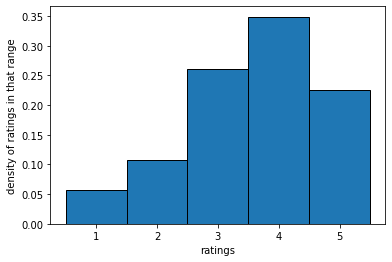

<Figure size 432x288 with 0 Axes>

In [44]:
ax = df['rating'].hist(bins = [0.5, 1.5, 2.5,3.5,4.5,5.5], ec='black', density = True)
plt.grid(None)
plt.xlabel("ratings")
plt.ylabel("density of ratings in that range")
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/rating_distribution')
plt.show()
plt.clf()

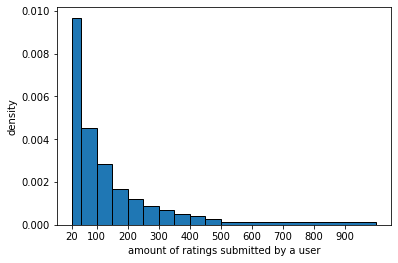

<Figure size 432x288 with 0 Axes>

In [45]:
counts = df['userId'].value_counts().values
plt.hist(counts, bins = [20,50,100,150,200,250,300,350,400,450,500,1000], ec='black', density = True)
plt.xlabel("amount of ratings submitted by a user")
plt.ylabel("density")
plt.xticks(np.concatenate((np.array([20]), np.arange(100, 1000, step=100)) ) )
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/rating_per_user')
plt.show()
plt.clf()

##**II) ItemKNN**

ItemKNN is a recommendation algorithm based on item similarities. There are 2 ways make a recommendation using ItemKNN: based on movie similarities (recommend movies similar to the ones the user has liked), or based on user similarities (recommend movies that similar users have liked). 

In this semester project’s implementation, it was chosen to make recommendations based on movie similarities. One of the advantages of this method is that movie similarities are much more static through time than user similarities, so the similarity matrix doesn’t have to be reprocessed as often. 

The similarity metrics used are the cosine similarity and the correlation score. We also save a matrix with the amount of corated users for each movie pair, which can be used as its own similarity score metric, or can be used to give an indication of how reliable the cosine/correlation scores are.

### Step 1: Calculating similarity matrices

For each pair of movies A and B, we first find all users that rated both A and B. Those users are denoted as the corated users and we store their amount in the corated_matrix array.

We then look at all of the ratings the corated users gave on ratings A and the ratings they gave to movie B. The cosine similarity and the correlation scores between the 2 arrays is used to calculate the similarity between movies A and B.



The cosine similarity is defined as:

$$cossim(A,B) = \frac{A \cdot B}{\lVert A \rVert \times \lVert B \rVert} = \dfrac{\sum\limits_{i=1}^{n} A_{i} \times B_{i}}{\sqrt{\sum\limits_{i=1}^{n} A_{i}^2} \times \sqrt{\sum\limits_{i=1}^{n} B_{i}^2}}$$

and the correlation is defined as:

$$corsim(A,B) = \dfrac{\sum\limits_{u \in U} (R_{u,A} - \overline{R_{u}})(R_{u,B} - \overline{R_{u}})}{\sqrt{\sum\limits_{u \in U} (R_{u,A} - \overline{R_{u}})^2}\sqrt{\sum\limits_{u \in U} (R_{u,B} - \overline{R_{u}})^2}}$$

where U the set of users that rated A and B


In [7]:
def generate_matrices(corated_matrix, cos_sim_matrix, correlation_matrix, start, end):
    for i in range(start, min(len(movies), end)):
        if(i%10 == 0 or i==len(movies)-1):
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/corated_matrix.npy', corated_matrix)
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/cos_sim_matrix.npy', cos_sim_matrix)
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/correlation_matrix.npy', correlation_matrix)
            print("saved at step", i)

        df1 = train_df[(train_df['movieId'] == i)]
        i_mean = np.mean(df1['rating'].values)

        for j in range(i+1,len(movies)):
            df2 = train_df[(train_df['movieId'] == j)]
            merged_inner = pd.merge(left=df1, right=df2, on='userId')
            corated_matrix[i][j] = len(merged_inner)
            corated_matrix[j][i] = len(merged_inner)

            if(len(merged_inner)>0):
                cos_simil = cosine_similarity([merged_inner['rating_x'].values], [merged_inner['rating_y'].values])[0]

                j_mean = np.mean(df2['rating'].values)
                i_ratings = merged_inner['rating_x'].values
                j_ratings = merged_inner['rating_y'].values

                divident = 0
                isquaredsum = 0
                jsquaredsum = 0
                for index in range(len(i_ratings)):
                    divident = divident + (i_ratings[index] - i_mean) * (j_ratings[index] - j_mean)
                    isquaredsum = isquaredsum + (i_ratings[index] - i_mean)**2
                    jsquaredsum = jsquaredsum + (j_ratings[index] - j_mean)**2

                divisor = math.sqrt(isquaredsum) * math.sqrt(jsquaredsum)
                cor_simil = 0
                if divisor !=0:
                    cor_simil = divident/divisor
            else:
                cos_simil = 0
                cor_simil = 0
    
            cos_sim_matrix[i][j] = cos_simil
            cos_sim_matrix[j][i] = cos_simil

            correlation_matrix[i][j] = cor_simil
            correlation_matrix[j][i] = cor_simil

In [5]:
# corated_matrix = np.zeros((len(movies), len(movies)))
# cos_sim_matrix = np.zeros((len(movies), len(movies)))
# correlation_matrix = np.zeros((len(movies), len(movies)))

corated_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/corated_matrix.npy')
cos_sim_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/cos_sim_matrix.npy')
correlation_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/correlation_matrix.npy')

In [ ]:
generate_matrices(corated_matrix, cos_sim_matrix, correlation_matrix, 110, 3706)

saved at step 110
saved at step 120


### Step 2: Recommending the movies

Recommendations are made based on the movies that the user has rated and the its similar movies. There are many ways one can choose to make a recommendation. The most basic method would be to look at the best rated item of the user we want to recommend to, and recommend the 10 movies that are the most similar to that movie.

In [6]:
cos_sim_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ItemKNN/cos_sim_matrix.npy")
correlation_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ItemKNN/correlation_matrix.npy")
corated_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/corated_count.npy")
recomAmount = 10

In [53]:
def basic_recommendation(simil_matrix, userId, recomAmount):
      rated_items = train_df[(train_df['userId'] == userId)]
      
      sorted_movies = rated_items.sort_values(by=['rating'], ascending = False)
      best_movieId = sorted_movies["movieId"].values[0]

      similarity = simil_matrix[best_movieId]
      args = similarity.argsort()[::-1]

      recom = []
      
      i = 0
      while(len(recom)<10):
        #only recommend movies that have not been rated already
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

      return recom

The performance metrics used are the Hit Ratio, which measures whether test items for a user are present in his recommendation list, and Normalized Discounted Cumulative Gain, which assesses the ranking quality of the test items.

In [54]:
def evaluateHR_NDCG(max_users = len(users), recommendation_method = basic_recommendation):
      ndcg = []
      hr = []

      for userId in range(0, max_users):
          top_predictions = recommendation_method(cos_sim_matrix, userId, recomAmount)

          user_rated = (test_df['userId'] == userId)
          user_movies = test_df[user_rated]['movieId'].values
          
          y_pred = np.asarray([[0 for i in range(recomAmount)]])
          y_true = np.asarray([[1 for i in range(recomAmount)]])

          hit_count = 0
          for i in range(0, recomAmount):
              if top_predictions[i] in user_movies:
                  y_pred[0][i] = 1
                  hit_count = hit_count+1
          
          ndcg.append(ndcg_score(y_pred, y_true))
          hr.append(hit_count/len(user_movies))

      return np.mean(hr), np.mean(ndcg)

In [ ]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = basic_recommendation)
print(hr)
print(ndcg)

As we can see, the recommendations are not great. The "basic recommendation" method isn't able to make recommendations that are meaningful enough.

Let's modify our recommendation function: Instead of recommending the most similar movies of the best rated item, we will look at all the best rated items by a user, and recommend the movies that are the most similar to that those.

In [81]:
def recommend_total_simil(simil_matrix, userId, recomAmount):
    rated_items = train_df[(train_df['userId'] == userId)]
    best_movies = rated_items[(rated_items['rating'] == max(rated_items['rating'].values))]['movieId'].values

    #1D array of similarity scores with movie
    similarity = np.array([0.0 for i in range(len(movies))])

    #only keep scores where corated > minCorated
    for i in range(len(movies)):
        for movie in best_movies:
            similarity[i] = similarity[i] + cos_sim_matrix[movie][i]

    args = similarity.argsort()[::-1]

    recom = []
    i = 0
    while(len(recom)<10):
        #only recommend movies the user hasn't rated yet
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

    return recom

In [83]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = recommend_total_simil)
print(hr)
print(ndcg)

0.0008
0.0036348474704706764


As we can see from the results, the recommendations are already much more meaningful than with the initial method. However, another problem that is hindering the performance of the model is that a pair of movies (A, B) with only one corated user (meaning there is only one user that rated movie A and movie B), may have a very high or very low similarity score simply by coincidence.

In the case where a user "Bob" gave movies (A,B) a rating of 4 and user "Jim" gave movies (A,B) a rating of 3, but no other user rated both movies (A,B), the similarity scores between both movies will be of 1.

In the case where there is only 1 corated user for 2 movies (A,B), the cosine similarity and correlation score will be 1, no matter what rating was given.

This shows that, when there is a small amount of corated users, the similarity scores can be artificially high.

In [ ]:
print(np.mean(corated_matrix))
print(np.median(corated_matrix))

plt.hist(corated_matrix, bins =[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,4000], ec='black', density=True)
plt.xlabel("amount of users that have rated both movies X and Y")
plt.ylabel("density")
plt.xlim(0, 10)
plt.xticks(np.arange(0, 10, step=1))
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/coratedZoomed')
plt.show()
plt.clf()

plt.hist(corated_matrix, bins =[0,5,10,20,30,40,50,60,70,80,90,100,4000], ec='black', density=True)
plt.xlabel("amount of users that have rated both movies X and Y")
plt.ylabel("density")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 100, step=10))
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/corated')
plt.show()
plt.clf()

We see that for each movie, there is a vast amount of other movies for which there is a very small amount of corated users. Let's look, for example, at the movies that are the most similar to the movie with id 500:

In [19]:
movieId = 500
scores = cos_sim_matrix[movieId]
sorted_scores = np.sort(scores)
print(sorted_scores[-20:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


There are many movies for which the cosine similarity is 1. Let's look at the amount of corated users they have:

In [47]:
max_args = np.argsort(scores)[-20:]
for arg in max_args:
    print(corated_matrix[movieId][arg])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
3.0
3.0


Due to the sparsity of he datasets, there is a vast amount of movie pairs that have a similarity score of 1.

Two movies that are very similar, for example "Back to the Future" and "Back to the Future 2", are very unlikely to have a score of 1 (only need one user to give a different score to "Back to the future" than he gave "Back to the Future 2"). The higher the amount of corated users, the harder it becomes for 2 movies to have a similarity score of 1, meaning that the current recommendation method will not be able to recommend the movies that are truly very similar.

This leads to recommendations not being very meaningful, as movies with a small amount of corated users will easily obtain a high score, no matter how similar they truly are.

To overcome this issue, there are 2 possible solutions:
- we can simply add a filter, and prevent recommendation for any movie where the amount of corated users is not high enough

- we can add a coefficient to the similarity score, such as sqrt(corated_amount)

The idea of the coefficient is that we heavily penalize pairs with a low amount of coratings. When the amount of corated users is high, the coefficient doesn't grow as fast anymore and we put more focus on the cosine similarity.

The amount of corated users provides a measure of how reliable the cosine similarity or correlation score is. On top of that, it also itself is a good metric of movie similarities: intuitively, we can assume that "Back to the future" and "Back to the future 2" will have a higher amount of corated users than "Back to the Future" and "The Simpsons" due to their similarity.

In [60]:
def recommend_corated_coeff(simil_matrix, userId, recomAmount):
    rated_items = train_df[(train_df['userId'] == userId)]
    max_items = (rated_items['rating'] == max(rated_items['rating'].values))
    
    best_movies = rated_items[max_items]['movieId'].values
    bestRatedAmount = len(best_movies)

    similarity = np.array([0.0 for i in range(len(movies))])
    for i in range(len(movies)):
        for movie in best_movies:
            similarity[i] = math.sqrt(corated_matrix[movie][i]) * simil_matrix[movie][i]

    args = similarity.argsort()[::-1]

    recom = []
    i = 0
    while(len(recom)<10):
        #only recommend movies the user hasn't rated yet
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

    return recom

In [63]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = recommend_corated_coeff)
print(hr)
print(ndcg)

0.0499
0.17209355750764957


With the new recommendation method, we obtain meaningful results in the range of what the research paper states can be obtained.

### ItemKNN Overview:

Advantages of itemKNN:
- Easy to give recommendations to a new user, as only 1 submitted rating is necessary.
- Explainable (“because similar to movie A”)

Disadvantages of itemKNN:
- New movies can’t be recommended without computing its similarity with every other movie.
- Similarity scores are very inaccurate for movies with few ratings. This means that new movies will
have very unreliable similarity scores until many ratings are added.

## III) BPR-MF